#### PREDICTING HEART DISEASE WITH LOGISTIC REGRESSION, KNN & GRIDSEARCHCV

**Data Dictionary**:

- age: in years

- sex: (1 = male; 0 = female)

- cp: chest pain type

- restbps: resting blood pressure (in mm Hg on admission to the hospital)

- chol: serum cholestorol in mg/dl

- fbsP: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

- restecg: resting electrocardiographic results

- thalach: maximum heart rate achieved

- exang: exercise induced angina (1 = yes; 0 = no)

- oldpeakST: depression induced by exercise relative to rest

- slope: the slope of the peak exercise ST segment

- ca: number of major vessels (0-3) colored by flourosopy

- thal:  3 = normal; 2 = fixed defect; 1 = reversable defect

- target: 1 or 0  Where 1 is Heart Disease, 0 is No Heart Disease

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore')

In [167]:
df= pd.read_csv('datasets/heart_2.csv')

In [168]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


#### Quick data cleaning

In [170]:
df.thal.value_counts()   #the data dictionary says it should be 1, 2 or 3, so I'm just going to replace the 0s with the mode

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [171]:
df['thal'] = df['thal'].replace(0, 2)

In [173]:
df['thal'].value_counts()

2    168
3    117
1     18
Name: thal, dtype: int64

In [174]:
df.shape

(303, 14)

In [175]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [176]:
dfd = pd.get_dummies(df, columns = ['cp', 'thal'], drop_first=True)

In [177]:
dfd.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,thal_2,thal_3
0,63,1,145,233,1,0,150,0,2.3,0,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,0,1,0,1,0,1,0
2,41,0,130,204,0,0,172,0,1.4,2,0,1,1,0,0,1,0
3,56,1,120,236,0,1,178,0,0.8,2,0,1,1,0,0,1,0
4,57,0,120,354,0,1,163,1,0.6,2,0,1,0,0,0,1,0


In [178]:
dfd.shape

(303, 17)

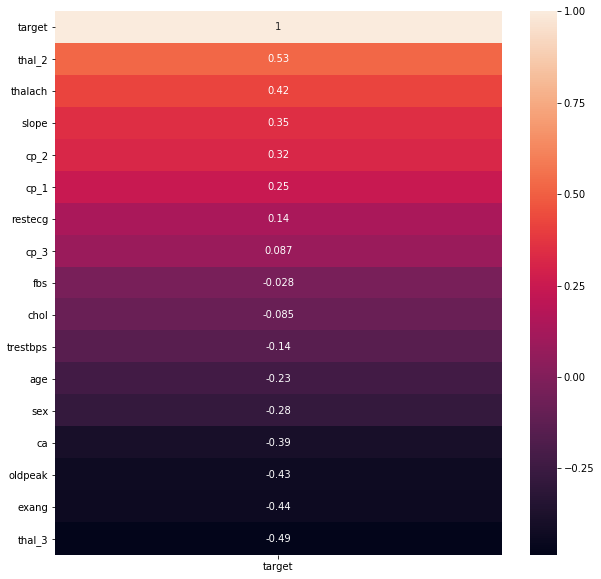

In [179]:
plt.figure(figsize = (10, 10))
corr = dfd.corr()
corr_sort = corr.sort_values(by = ['target'], axis = 0, ascending = False)
sns.heatmap(corr_sort[['target']], annot=True)

#### Create our feature matrix based on the features with a correlation of  greater than +0.3 and less than -0.3

In [188]:
X = dfd[['thal_2','thalach', 'slope', 'cp_2', 'thal_3','exang', 'oldpeak', 'ca']]
y = dfd['target']

In [189]:
y.value_counts()

1    165
0    138
Name: target, dtype: int64

#### Train Test Split

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11)

In [191]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((242, 8), (242,), (61, 8), (61,))

#### Scale our data! 
   - Logistic Regression in Sklearn does Ridge regularization by default and KNN is distanced based, so we want to make sure our data is scaled

In [194]:
ss = StandardScaler()

In [195]:
Xs_train  = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

#### Instantiate Logistic Regression

In [196]:
logreg = LogisticRegression()

#### Checkout a cross_val_score to see what we should expect from our model:

In [197]:
cross_val_score(logreg, Xs_train, y_train).mean()

0.8262860082304527

#### Fit and score our model

In [198]:
logreg.fit(Xs_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [199]:
logreg.score(Xs_train, y_train)

0.8388429752066116

In [200]:
logreg.score(Xs_test, y_test)

0.8032786885245902

In [121]:
logreg.predict_proba(Xs_test)[:5]        #These are our probabilities of going into either class

array([[0.96625258, 0.03374742],
       [0.06992542, 0.93007458],
       [0.37405099, 0.62594901],
       [0.94574675, 0.05425325],
       [0.12336918, 0.87663082]])

In [122]:
logreg.predict(Xs_test)

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1])

#### Use np.exp() to exponentiate the coefficients.

In [201]:
coefs = np.exp(logreg.coef_)
cols = X.columns

In [202]:
list(zip(coefs[0], cols))


[(1.2733799501971, 'thal_2'),
 (1.9044697093212772, 'thalach'),
 (1.2695813424377154, 'slope'),
 (1.8869319426821318, 'cp_2'),
 (0.39983423877478974, 'thal_3'),
 (0.7744901927535551, 'exang'),
 (0.6852954056402009, 'oldpeak'),
 (0.33390833914477813, 'ca')]

### Let's see how KNN does...

In [203]:
from sklearn.neighbors import KNeighborsClassifier

In [204]:
knn = KNeighborsClassifier()

In [205]:
knn.fit(Xs_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [206]:
knn.score(Xs_train, y_train)

0.8677685950413223

In [207]:
knn.score(Xs_test, y_test)    

0.7540983606557377

#### What can we say about our KNN model relative to our Logistic Regression Model?

### Let's Tune some hyperparameters!

In [208]:
from sklearn.model_selection import GridSearchCV

- Use Gridsearch to tune hyperparameters
- We can GridSearch over the hyperparameters available within a model to find the optimal combination
- We can start by checking out what hyperparameters are available in our model... check the docs!

GridSearchCV Docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Logistic Regression Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [219]:
parameters = [{'penalty': ['l1', 'l2'],        
                     'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1], 
              'class_weight': [None, 'balanced']}]  
#penalty: #Lasso or Ridge Regularization
#C is the inverse of the regularization strength - the lower the number, stronger the regularization strength
#class_weight: does the algorithm adds additional weight to the minority class to balance the classes

In [220]:
lr = LogisticRegression()

In [221]:
gs = GridSearchCV(estimator = lr,
                  param_grid = parameters, 
                  cv=5)

In [222]:
gs.fit(Xs_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1], 'class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [223]:
gs_lr = gs.best_estimator_    

In [224]:
gs_lr    
#now this becomes our new model object 
#this is our logistic regression with the best hyperparameter combination

LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [225]:
gs_lr.get_params()   
#this tells you the parameters it determined were optimal 

{'C': 1e-06,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [226]:
gs_lr.fit(Xs_train, y_train)

LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [238]:
gs_lr.score(Xs_train, y_train), logreg.score(Xs_train, y_train)

(0.8429752066115702, 0.8388429752066116)

In [237]:
gs_lr.score(Xs_test, y_test), logreg.score(Xs_test, y_test)

(0.7704918032786885, 0.8032786885245902)

In [239]:
#What can we say when comparing about these logistic regression models?

#### Let's GridSearch over our KNN Model:
   - Using the above example as a template and the KNN documentation below, create a param grid for the KNN model:
   - KNN docs: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [240]:
params = [{'n_neighbors': [3, 5, 7],
           'weights': ['uniform', 'distance'],
           'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
           'metric' : ['euclidean', 'minkowski', 'manhattan'],
          }]  

In [241]:
kn = KNeighborsClassifier()

In [242]:
grid = GridSearchCV(estimator = kn,
                  param_grid = params, 
                  cv=5)

In [243]:
grid.fit(Xs_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'metric': ['euclidean', 'minkowski', 'manhattan']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [244]:
gs_knn = grid.best_estimator_
gs_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [245]:
gs_knn.fit(Xs_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [248]:
gs_knn.score(Xs_train, y_train), knn.score(Xs_train, y_train)

(0.8636363636363636, 0.8677685950413223)

In [249]:
gs_knn.score(Xs_test, y_test), knn.score(Xs_test, y_test)

(0.7213114754098361, 0.7540983606557377)